# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22 
### Date Last Modified: 2024-04-22

In [1]:
!nvidia-smi

Mon Apr 22 03:35:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              N/A /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
 # We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [60]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [20]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [21]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


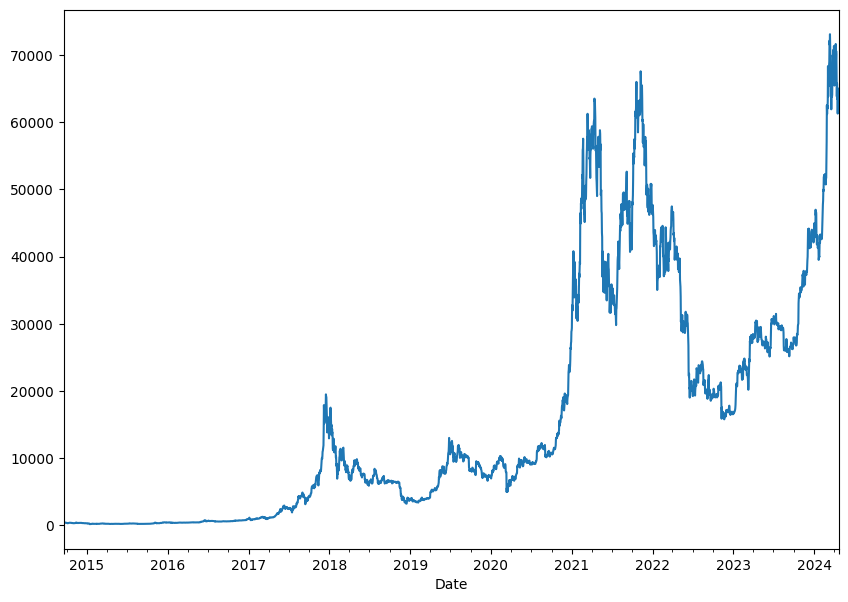

In [22]:
dataframe['Close'].plot(figsize=(10, 7));

In [37]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)

In [43]:
# Normalizing the data
scaler = MinMaxScaler()
btcc_prices["Price"] = scaler.fit_transform(btcc_prices)
scaler.inverse_transform()
btcc_prices.head()

,Price
Date,
2014-09-17,0.003830
2014-09-18,0.003379
2014-09-19,0.002972
2014-09-20,0.003166
2014-09-21,0.003027


In [44]:
# Split data into train and test sets (80% - 20%)
timestamps = btcc_prices.index.to_numpy()
prices = btcc_prices["Price"].to_numpy()
split_size = int(0.8 * len(btcc_prices))

X_train, y_train = timestamps[:split_size], prices[:split_size]
X_test, y_test = timestamps[split_size:], prices[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2804, 2804, 701, 701)

In [55]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """ 
    Plots a series of timestamps against values.
    
    Parameters
    ----------
    timestamps : list 
        list of timestamp values
    values : list 
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


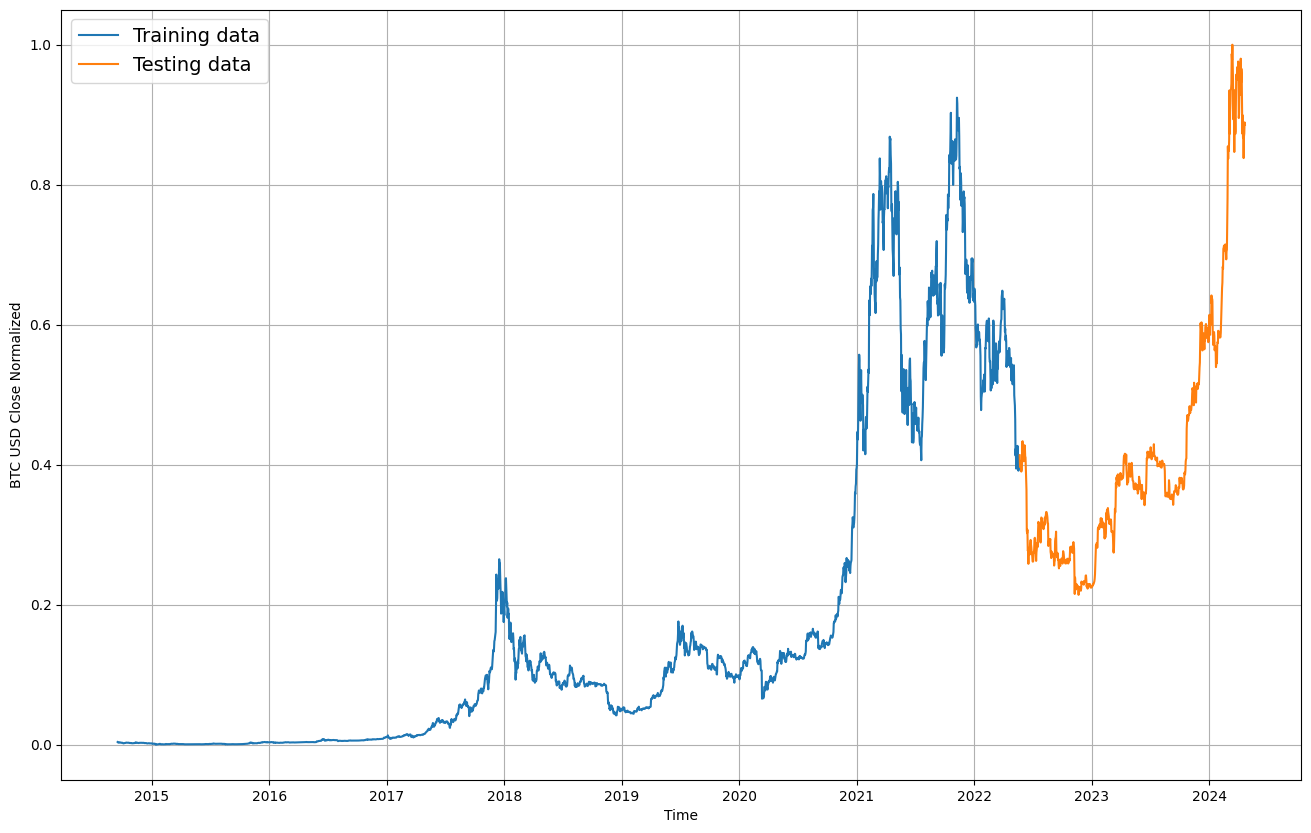

In [56]:
plt.figure(figsize=(16, 10))
plot_time_series(timestamps=X_train, values=y_train, title="Training data")
plot_time_series(timestamps=X_test, values=y_test, title="Testing data", yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [57]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values
        
    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [61]:
WINDOW_SIZE = 7
HORIZON = 1

In [62]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [63]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g. 
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8,)
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [64]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [66]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(*make_windows(prices))
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2798, 700, 2798, 700)

In [69]:
train_windows[:3], train_labels[:3]

(array([[0.00383005, 0.00337886, 0.00297225, 0.00316576, 0.00302746,
         0.00307315, 0.00353455],
        [0.00337886, 0.00297225, 0.00316576, 0.00302746, 0.00307315,
         0.00353455, 0.00336192],
        [0.00297225, 0.00316576, 0.00302746, 0.00307315, 0.00353455,
         0.00336192, 0.00320238]]),
 array([[0.00336192],
        [0.00320238],
        [0.00310432]]))

## Prepare Utilities for Training

In [70]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=1,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

### FNN (Feed-forward, Densely Connected Network)

In [159]:
model_fnn_w7h1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear")
], name="FNN_W7_H1")

model_fnn_w7h1.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["mae", "mse", "mape"])

history_1 = model_fnn_w7h1.fit(train_windows,
                               train_labels,
                               epochs=100,
                               batch_size=128,
                               validation_data=(test_windows, test_labels),
                               callbacks=[
                            create_model_checkpoint(model_name=model_fnn_w7h1.name),
                            create_early_stopping(patience=8)
                        ])

Epoch 1/100
 1/22 [>.............................] - ETA: 28s - loss: 0.1482 - mae: 0.1482 - mse: 0.0598 - mape: 88.6810
Epoch 1: val_loss improved from inf to 0.01500, saving model to model_experiments/FNN_W7_H1
22/22 [==============================] - 2s 23ms/step - loss: 0.0539 - mae: 0.0539 - mse: 0.0144 - mape: 8322.7344 - val_loss: 0.0150 - val_mae: 0.0150 - val_mse: 5.1325e-04 - val_mape: 3.6747
Epoch 2/100
 1/22 [>.............................] - ETA: 0s - loss: 0.0165 - mae: 0.0165 - mse: 4.0083e-04 - mape: 219.2333
Epoch 2: val_loss did not improve from 0.01500
22/22 [==============================] - 0s 3ms/step - loss: 0.0119 - mae: 0.0119 - mse: 4.4073e-04 - mape: 3682.3228 - val_loss: 0.0160 - val_mae: 0.0160 - val_mse: 5.3142e-04 - val_mape: 3.9871
Epoch 3/100
 1/22 [>.............................] - ETA: 0s - loss: 0.0106 - mae: 0.0106 - mse: 4.6602e-04 - mape: 35.0023
Epoch 3: val_loss did not improve from 0.01500
22/22 [==============================] - 0s 3ms/step - 

In [160]:
model_fnn_w7h1.evaluate(test_windows, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.0086 - mae: 0.0086 - mse: 1.9408e-04 - mape: 2.0316


[0.008552568964660168,
 0.008552568964660168,
 0.00019408400112297386,
 2.0316107273101807]

In [161]:
model_fnn_w7h1_preds = tf.squeeze(model_fnn_w7h1.predict(test_windows))
model_fnn_w7h1_preds

22/22 [==============================] - 0s 813us/step


<tf.Tensor: shape=(700,), dtype=float32, numpy=
array([0.41342285, 0.40350917, 0.40285972, 0.40713155, 0.40040493,
       0.396097  , 0.39247906, 0.39970452, 0.42173627, 0.43717515,
       0.41992554, 0.416828  , 0.4127454 , 0.40437433, 0.40971616,
       0.41990104, 0.4294881 , 0.41854608, 0.41505954, 0.4037937 ,
       0.38991323, 0.3733342 , 0.32612815, 0.29923606, 0.30234465,
       0.2810227 , 0.27434266, 0.26627114, 0.2674583 , 0.28213516,
       0.2791128 , 0.2793214 , 0.28163058, 0.29086423, 0.29127955,
       0.29185036, 0.28484115, 0.28026265, 0.2746457 , 0.27139834,
       0.26474705, 0.26209447, 0.26248652, 0.27033567, 0.2763505 ,
       0.27860358, 0.29165095, 0.29736513, 0.2967992 , 0.2908487 ,
       0.27769372, 0.26705092, 0.26971966, 0.2780369 , 0.2819178 ,
       0.2888819 , 0.28694546, 0.29874474, 0.31693575, 0.3185631 ,
       0.31997547, 0.31483495, 0.308833  , 0.3085004 , 0.29801208,
       0.28940699, 0.30452976, 0.32022294, 0.3259596 , 0.3267751 ,
       0.32276

In [172]:
test_labels

array([[0.39668952],
       [0.40432511],
       [0.40304641],
       [0.39899819],
       [0.39022449],
       [0.39279393],
       [0.40144976],
       [0.43272911],
       [0.4336333 ],
       [0.40629334],
       [0.4154615 ],
       [0.40499454],
       [0.40675742],
       [0.40776898],
       [0.42784993],
       [0.42489825],
       [0.41198942],
       [0.41058545],
       [0.39648233],
       [0.38656545],
       [0.36464441],
       [0.30600321],
       [0.30215445],
       [0.3071753 ],
       [0.27712005],
       [0.27835222],
       [0.25841077],
       [0.27947408],
       [0.28010867],
       [0.28163203],
       [0.27170727],
       [0.28677951],
       [0.28877908],
       [0.29249186],
       [0.28597597],
       [0.2819733 ],
       [0.27573448],
       [0.27331201],
       [0.2689324 ],
       [0.26186352],
       [0.26149165],
       [0.26224359],
       [0.27505726],
       [0.27449288],
       [0.27940515],
       [0.294347  ],
       [0.29562989],
       [0.293

In [173]:
scaler.inverse_transform(test_labels)

array([[0.39668952],
       [0.40432511],
       [0.40304641],
       [0.39899819],
       [0.39022449],
       [0.39279393],
       [0.40144976],
       [0.43272911],
       [0.4336333 ],
       [0.40629334],
       [0.4154615 ],
       [0.40499454],
       [0.40675742],
       [0.40776898],
       [0.42784993],
       [0.42489825],
       [0.41198942],
       [0.41058545],
       [0.39648233],
       [0.38656545],
       [0.36464441],
       [0.30600321],
       [0.30215445],
       [0.3071753 ],
       [0.27712005],
       [0.27835222],
       [0.25841077],
       [0.27947408],
       [0.28010867],
       [0.28163203],
       [0.27170727],
       [0.28677951],
       [0.28877908],
       [0.29249186],
       [0.28597597],
       [0.2819733 ],
       [0.27573448],
       [0.27331201],
       [0.2689324 ],
       [0.26186352],
       [0.26149165],
       [0.26224359],
       [0.27505726],
       [0.27449288],
       [0.27940515],
       [0.294347  ],
       [0.29562989],
       [0.293

In [175]:
model_fnn_w7h1_res = evaluate_pred(y_true=tf.squeeze(scaler.inverse_transform(test_labels)),
                                 y_pred=scaler.inverse_transform(tf.expand_dims(model_fnn_w7h1_preds, 0)))
model_fnn_w7h1_res

{'mae': 0.008552568,
 'mse': 0.000194084,
 'rmse': 0.013931404,
 'mape': 2.0316112}